<a href="https://colab.research.google.com/github/lucashofer/atomcloud/blob/main/docs/notebooks/Multi_Function_Fits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Function Fits

Here we show the basics of using AtomCloud to fit data. We recommend first going through the MultiFunction notebook as it gives insight into the multifunction fits.

First let's install AtomCloud and JAXFit (for GPU acceleration).

In [1]:
!pip install jaxfit
!pip install atomcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 8.6 MB/s eta 0:00:00


Let's get some example data of a bimodal distribution and plot the data

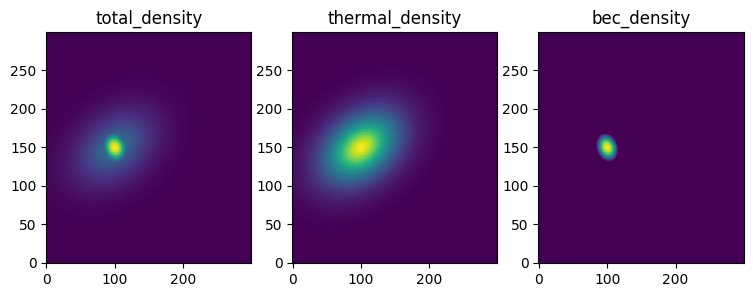

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from atomcloud import example_data

XY_tuple, densities, parameters = example_data.get_example_data()
total_density, thermal_density, bec_density, offset = densities

labels = ['total_density', 'thermal_density', 'bec_density']

fig, axes = plt.subplots(1, 3, figsize = (9, 3))

for ax, density, label in zip(axes, densities, labels):
    ax.pcolormesh(*XY_tuple, density,shading='auto')
    ax.set_title(label)

## 1D MultiFunction Fits

Now for simplicity, let's start by looking at 1D fits. We'll first use some of AtomCloud's built in functions to take the 2D data and sum it along both the x and y axes.

Text(0.5, 1.0, 'ysum')

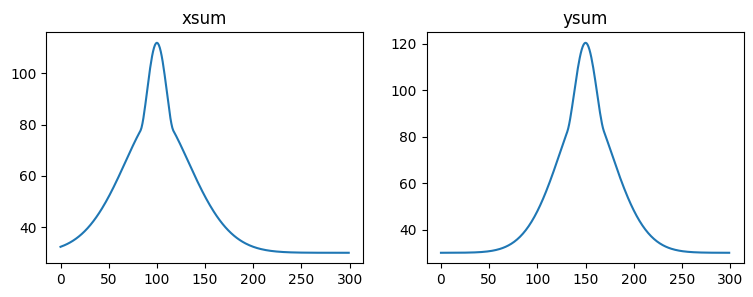

In [3]:
from atomcloud.utils import img_data_to_sums

x, y, xsum, ysum = img_data_to_sums(XY_tuple, total_density)

fig, axes = plt.subplots(1, 2, figsize = (9, 3))

axes[0].plot(x, xsum)
axes[0].set_title('xsum')

axes[1].plot(y, ysum)
axes[1].set_title('ysum')

Now let's do a 1D fit with a Gaussian. Internally, the multifunction fit objects
use the multifunction objects (see the MultiFunction notebook) to do the fitting. This means we pass the equations and constraints in the same way as we did in the MultiFunction notebook when initializing the multifunction object.

In this first example we ignore the constraints and just fit a Gaussian with an
offset. The output of the fit is a list of the fit parameters and a dictionary
which contains all the information about the fit (including the fit parameters).

In [4]:
from atomcloud.fits import MultiFit1D

gauss1d_eqs = ['gaussian', 'foffset']

gauss1d_fit_obj = MultiFit1D(gauss1d_eqs)
params, gauss1d_fit_dict = gauss1d_fit_obj.get_fit(x, xsum)

for key, item in gauss1d_fit_dict.items():
    print(key)
    print(item)
    print('-'*20)

fit_type
1d
--------------------
equations
['gaussian', 'foffset']
--------------------
constraints
None
--------------------
params
[[64.07580437020107, 31.092586018452234, 99.9980948247536], [31.918460219430933]]
--------------------
fit_metrics
{'chi_squared': 5766.650373726157, 'chi_squared_red': 19.351175750758916}
--------------------
data_sum
14566.384037345959
--------------------


We can see that the fit parameters are given in the same format as described in
the MultiFunction notebook. Furthermore, the fit metrics and the sum of the
data fitted is included. Finally, the equations and constraints are also
included in the dictionary, along with the fit type. These can all be used to
recreate the fit object or simply create a multifunction object with the same
parameters.

The plot_fitdict function does this internally and plots the fit.

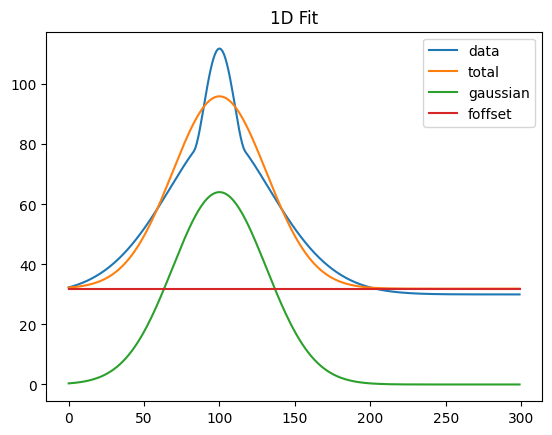

In [5]:
from atomcloud.process_fits import plot_fitdict

plot_fitdict(gauss1d_fit_dict, x, xsum)

We can see in the plot above that this function plots the original data, the total fit and then each of the sub-functions which comprise the total fit.

Now this is clearly a bimodal distribution so let's use a bimodal fit

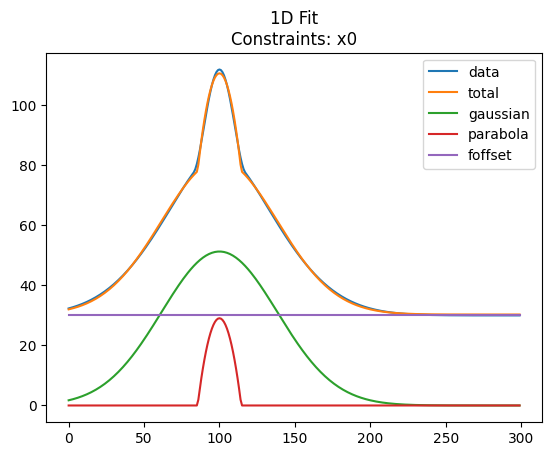

In [6]:
bimodal1d_eqs = ['gaussian', 'parabola', 'foffset']
bimodal1d_constraints = ['x0']

bimodal1d_fit_obj = MultiFit1D(bimodal1d_eqs, bimodal1d_constraints)
params, bimodal1d_fit_dict = bimodal1d_fit_obj.get_fit(x, xsum)
plot_fitdict(bimodal1d_fit_dict, x, xsum)

This worked fine, with the MultiFit's default seed value. Often, however, the internal seed value is not good enough and the fit will fail (particularly for 2D fits). In this case it's good to pass in seed parameters.

The seed parameters need to be in the same format as the input argument for the MultiFunction object (see the MultiFunction notebook), that is we need a list of list where each sublist is the parameters for one of the subfuntions. Let's try this with a bimodal fit. We'll use the parameters from the Gaussian fit to create the seed.

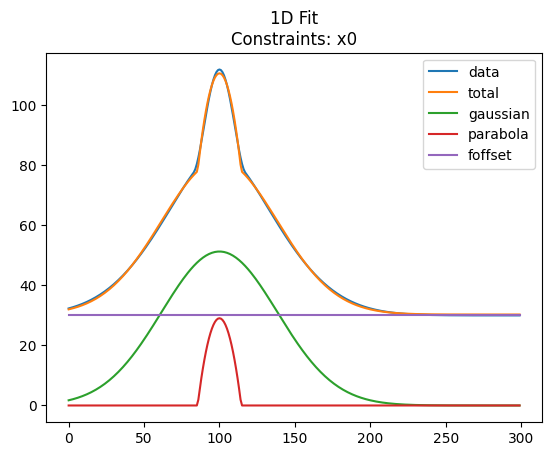

In [7]:
gauss_params, offset_params = gauss1d_fit_dict['params']


parabola_params = gauss_params.copy()
parabola_params[1] /= 2

bimodal1d_seed = [gauss_params, parabola_params, offset_params]

params, bimodal1d_fit_dict = bimodal1d_fit_obj.get_fit(x, xsum, bimodal1d_seed)
plot_fitdict(bimodal1d_fit_dict, x, xsum)

As can be seen it sometimes makes sense to use a more simple fit to find seed parameters for the actual (and more complex) fit you wish to achieve.

## 2D MultiFunction Fits

Now we can try the same thing with 2D data. We'll use the full 2D data rather than the sums.

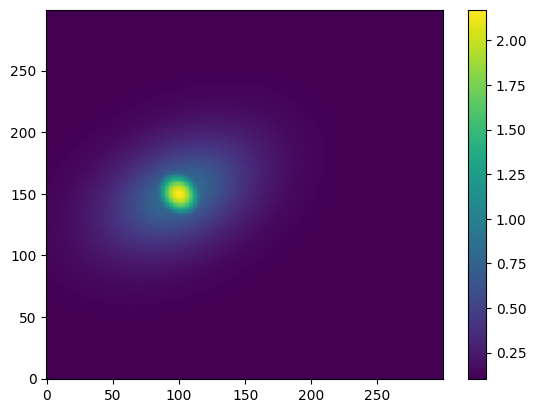

In [8]:
plt.figure()
plt.pcolormesh(*XY_tuple, total_density, shading='auto')
plt.colorbar()
plt.show()

Now similar to the 1D case we import the 2d MultiFit object and create a fit object. We'll use the same Gaussian fit as before.

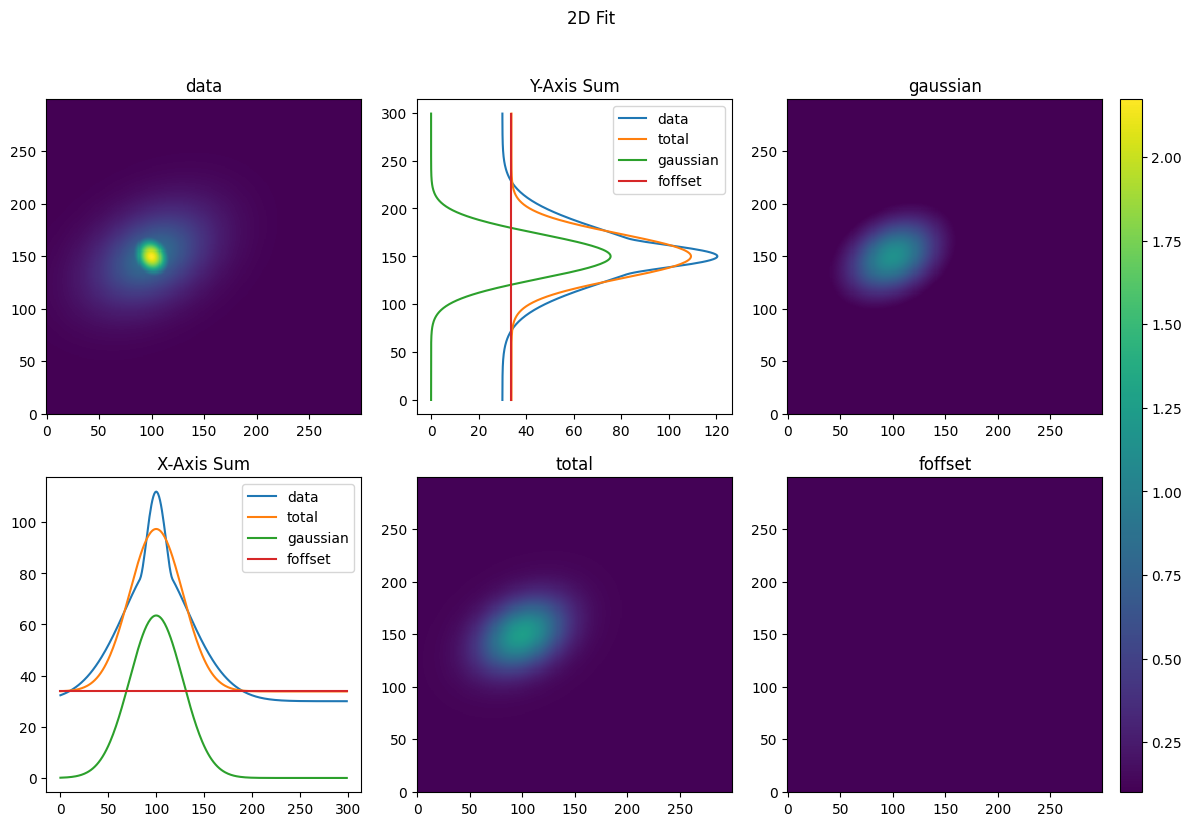

In [9]:
from atomcloud.fits import MultiFit2D

gauss2d_eqs = ['gaussian', 'foffset']

#construct a 2d seed from the 1d seed
n0, std, rx = gauss_params
theta = 0
gauss2d_params = [n0, rx, rx, std, std, theta]
gauss2d_seed = [gauss2d_params, offset_params]

#fit the 2d data
gauss2d_fit_obj = MultiFit2D(gauss2d_eqs, scipy_length=1E6)
params, gauss2d_fit_dict = gauss2d_fit_obj.get_fit(XY_tuple, total_density,
                                                   gauss2d_seed)
#plot the 2d fit
plot_fitdict(gauss2d_fit_dict, XY_tuple, total_density)

The seed is essential here or the fit will fail. Let's use the Gaussian fit to seed a bimodal fit.

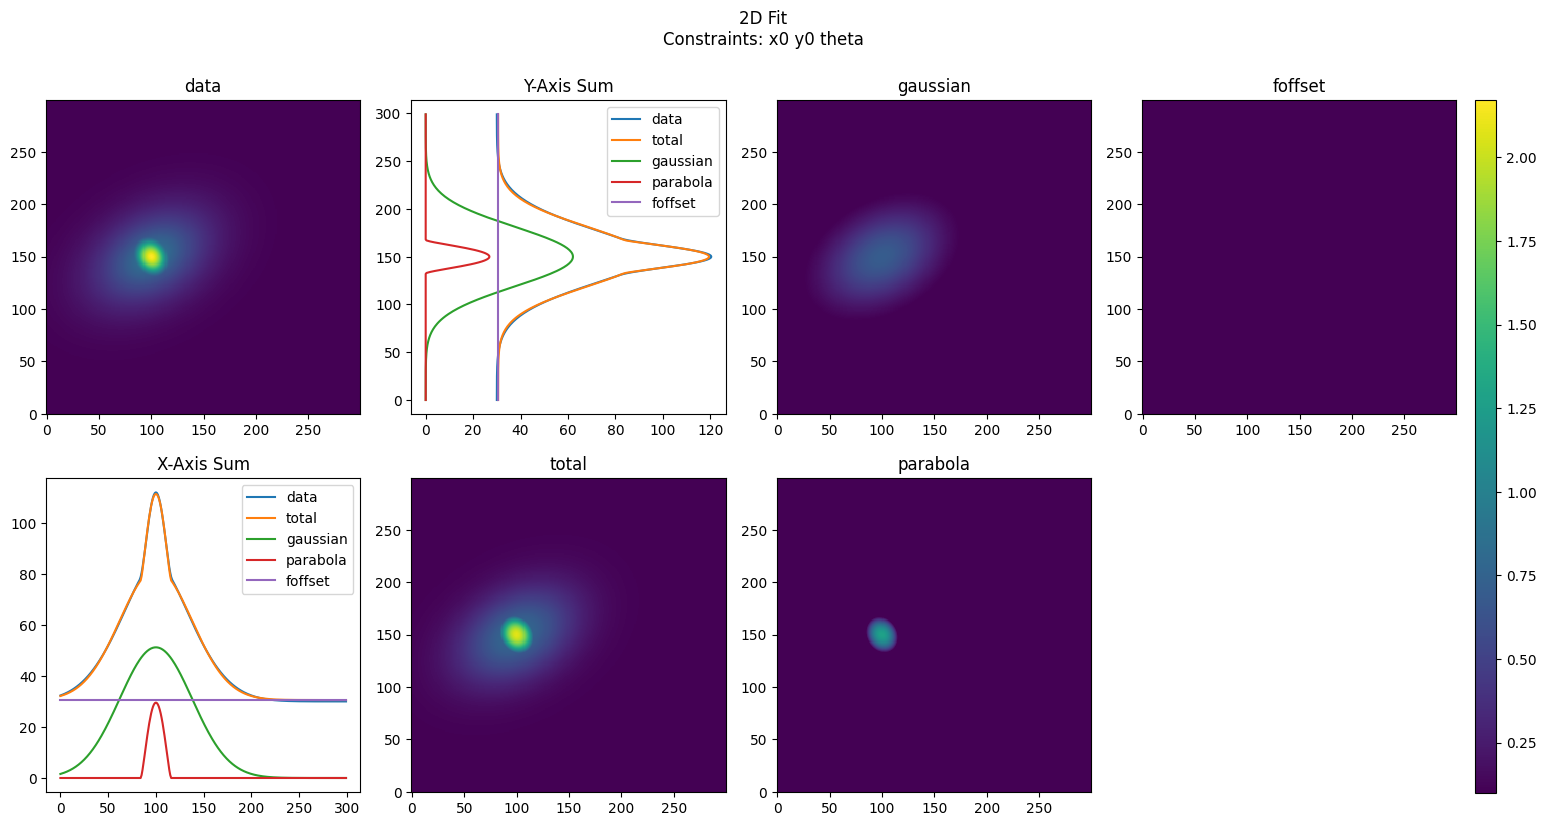

In [10]:
#construct the bimodal seed
gauss2d_params, offset_params = gauss2d_fit_dict['params']
parabola2d_params = gauss2d_params.copy()
parabola2d_params[3] /= 2
parabola2d_params[4] /= 2
bimodal2d_seed = [gauss2d_params, parabola2d_params, offset_params]

#construct the 2d bimodal fitting object
bimodal2d_eqs = ['gaussian', 'parabola', 'foffset']
bimodal2d_constraints = ['x0', 'y0', 'theta']
bimodal2d_fit_obj = MultiFit2D(bimodal2d_eqs, bimodal2d_constraints,
                               scipy_length=1E6)

#do the fit
params, bimodal2d_fit_dict = bimodal2d_fit_obj.get_fit(XY_tuple, total_density,
                                                       bimodal2d_seed)
#plot the fit
plot_fitdict(bimodal2d_fit_dict, XY_tuple, total_density)

## Scipy vs. JAXFit

AtomCloud is able to use either Scipy or JAXFit to do the fitting. JAXFit is able to take advantage of GPU acceleration to drastically increase the speed of fits---particularly for 2D fits. However, for small fits (data length<$10^3$) SciPy is faster. Here we show how to set the fitting method.

We'll use the bimodal fit from above but include two extra parameters in the
fit object instantiation. The first is scipy_length. Any data passed for fitting
which is less than or equal to this length will be fit using SciPy. This value
has a default of 1000.

However, we note that if JAX and JAXFit are not installed then the fit will
default to SciPy.

We instantiate two separate fit objects, one in which the scipy_length is set to inf and which will therefore use SciPy. For the other we set the scipy_length to 0 and it will therefore use JAXFit.

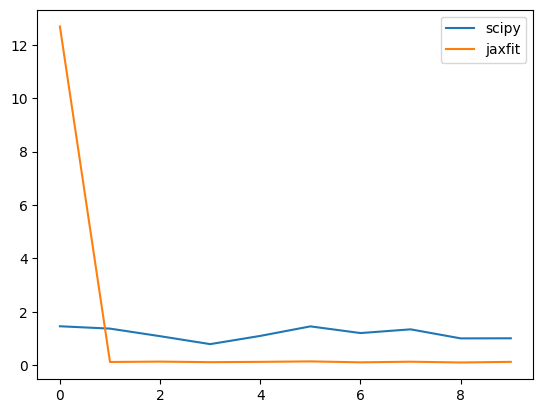

In [11]:
import time

bimodal_scipy_obj = MultiFit2D(bimodal2d_eqs,
                               bimodal2d_constraints,
                               scipy_length=np.inf)

bimodal_jax_obj = MultiFit2D(bimodal2d_eqs,
                             bimodal2d_constraints,
                             scipy_length=0)


scipy_times = []
jaxfit_times = []

for i in range(10):
    scipy_time = time.time()
    params, scipy_fit_dict = bimodal_scipy_obj.get_fit(XY_tuple, total_density,
                                                       bimodal2d_seed,
                                                       verbose=False)
    scipy_times.append(time.time() - scipy_time)

    jaxfit_time = time.time()
    params, jax_fit_dict = bimodal_jax_obj.get_fit(XY_tuple, total_density,
                                                   bimodal2d_seed,
                                                   verbose=False)
    jaxfit_times.append(time.time() - jaxfit_time)

plt.figure()
plt.plot(scipy_times, label='scipy')
plt.plot(jaxfit_times, label='jaxfit')
plt.legend()
plt.show()

The first fit is always slow for JAXFit as it is tracing the fitting function; however using a GPU shows significantly faster fits that SciPy for successive fits.

Generally, we recommend sticking with the default value where the scipy_length=1000.

### JAXFit Fixed Length
If the size of your data changes between get_fit calls JAXFit can run very slowly. This is because JAX must retrace a function whenever the size of the input array changes. However, JAXFit has a clever way of getting around this. We set a fixed data size (which should be greater than or equal to the largest data we’ll fit) and then we use dummy data behind the scenes to keep the array sizes fixed.

AtomCloud's fit objects have a fixed_length argument which is then passed to the JAXFit object inside. We do the same fits as above, but this time we set a fixed array size length when we instantiate the fit object.

Since our data is 512x512 we set the fixed_length to $600^2$. Thus if we have
a slightly large image we can still fit it without having to retrace the
function.

In [12]:
fixed_jax_obj = MultiFit2D(bimodal2d_eqs,
                           bimodal2d_constraints,
                           scipy_length=0,
                           fixed_length=600**2)

params, jax_fit_dict = fixed_jax_obj.get_fit(XY_tuple, total_density,
                                             bimodal2d_seed)

## Additional Fit Options

The get_fit function for both the 1d and 2d fit objects are inherited from the
same base object and thus each have a number of additional arguments which can
be passed to them.

For instance we can pass bounds to an individual fit function rather than using the default bounds.



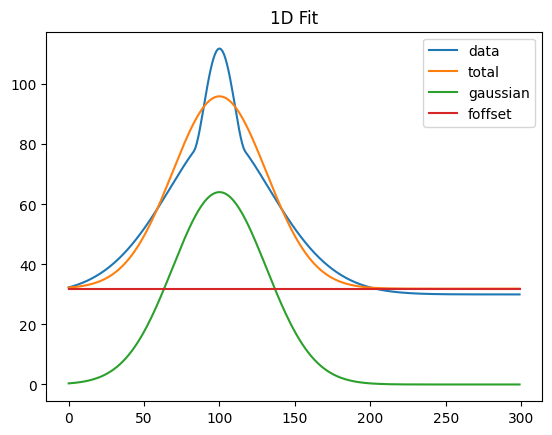

In [13]:

gauss1d_min_bounds = [0, -np.inf, 0]
offset_min_bounds = [-np.inf]
min_bounds = [gauss1d_min_bounds, offset_min_bounds]

gauss1d_max_bounds = [np.inf, np.inf, np.inf]
offset_max_bounds = [np.inf]
max_bounds = [gauss1d_max_bounds, offset_max_bounds]

bounds = [min_bounds, max_bounds]

gauss1d_eqs = ['gaussian', 'foffset']
gauss1d_fit_obj = MultiFit1D(gauss1d_eqs)
params, gauss1d_fit_dict = gauss1d_fit_obj.get_fit(x, xsum, bounds=bounds)

plot_fitdict(gauss1d_fit_dict, x, xsum)

We can also pass a mask to the fit function (the size/shape of the mask must match the size/shape of the fit data). Only those points where the mask is True will be used in the fit. This is useful if you want to mask out part of a fit (e.g. the BEC and only fit the thermal cloud).

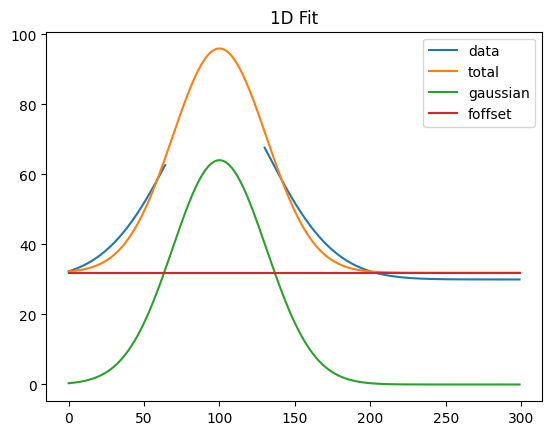

In [14]:
mask = np.ones_like(xsum, dtype=bool)
mask[65:130] = False

mask_fit_obj = MultiFit1D(gauss1d_eqs)
params, mask_fit_dict = mask_fit_obj.get_fit(x, xsum, uncertainty=True)

plot_fitdict(mask_fit_dict, x, xsum, mask=mask)

We can also have all the parameters returned with their respective errors. This uses the uncertainties package incorporated the covariance matrix from the fit into the fit parameters directly.

In [15]:
gauss1d_fit_obj = MultiFit1D(gauss1d_eqs)
params, gauss1d_fit_dict = gauss1d_fit_obj.get_fit(x, xsum, uncertainty=True)

print(gauss1d_fit_dict['params'])

[[64.07580437020107+/-0.7769261110053101, 31.092586018452234+/-0.48166893947271944, 99.9980948247536+/-0.4080292799181895], [31.918460219430933+/-0.37799182862053254]]


Finally, we can also pass in an array sigma with the same size/shape as the data. This will then be used as the sigma for the fit. This is useful if you have a 2D image and you want to weight the fit by the uncertainty in each pixel.

## Processing Fits

Post-processing fits to rescale fit parameters or integrate the fits is a task that is often required. AtomCloud natively includes post-processing functions for fits---which again are defined the the sub-function fit objects.

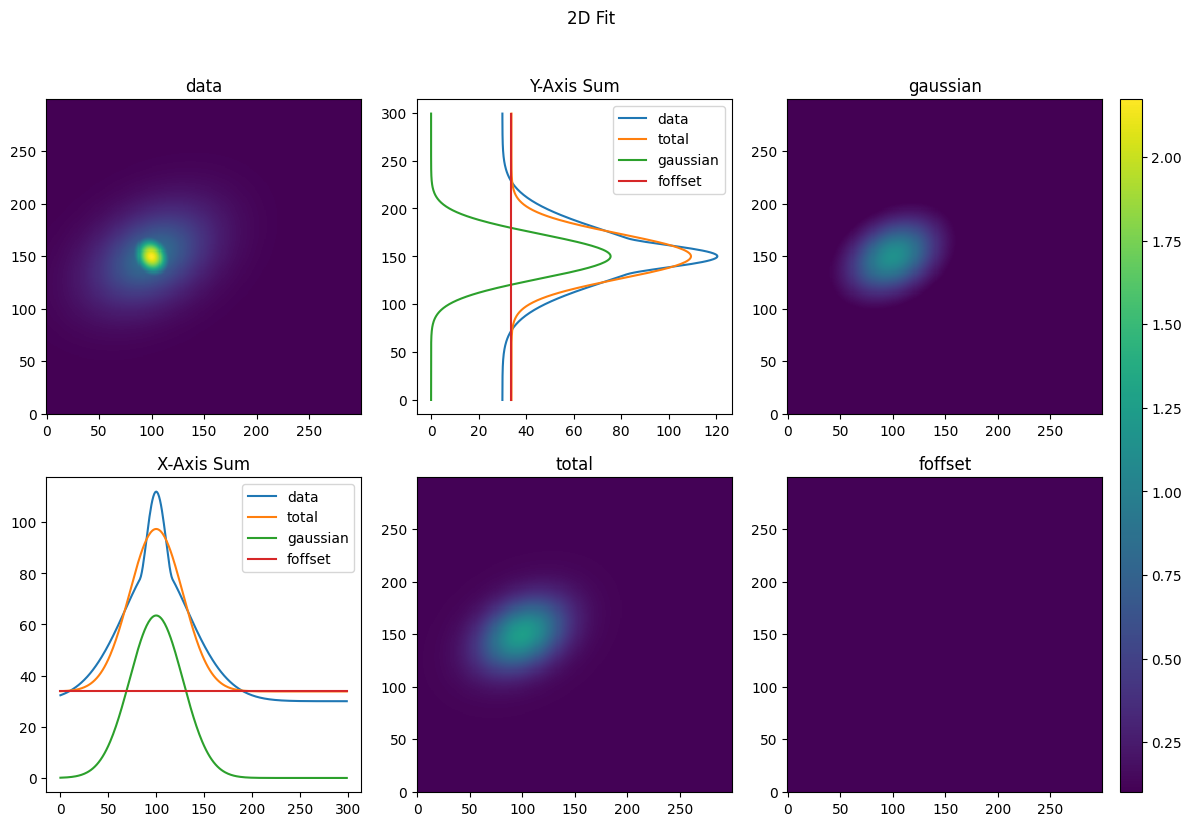

fit_type
2d
--------------------
equations
['gaussian', 'foffset']
--------------------
constraints
None
--------------------
params
[[1.1381507039530432, 100.00014315653125, 150.00004363567518, 20.7885300951148, 29.741342720306974, -140.3244948332416], [0.11272884748729266]]
--------------------
fit_metrics
{'chi_squared': 286.38039945365927, 'chi_squared_red': 0.0031820751511551287}
--------------------
data_sum
14566.384037345957
--------------------
analysis_params
[{'sigxx': 27.77485095593187, 'sigyy': 23.350976525576417, 'int': 4421.442625353453}, {}]
--------------------


In [16]:
from atomcloud.process_fits import process_fitdict

#fit the 2d data
gauss2d_fit_obj = MultiFit2D(gauss2d_eqs, scipy_length=1E6)
params, gauss2d_fit_dict = gauss2d_fit_obj.get_fit(XY_tuple, total_density,
                                                   gauss2d_seed)
#plot the 2d fit
plot_fitdict(gauss2d_fit_dict, XY_tuple, total_density)

analyzed_fit_dict = process_fitdict(gauss2d_fit_dict, analyze=True)

for key, item in analyzed_fit_dict.items():
    print(key)
    print(item)
    print('-'*20)

And we can now see the fit_dict now includes an analysis_params key, where for the 2D Gaussian fit we have the integrated number of atoms as well as the standard deviation of the fit along the x and y axes (the fit parameters have the standard deviations of the distribution along the rotated major and minor axes).

Now let's try rescaling the fit parameters along all three axes as we often need to move from pixels to SI units. We'll use the same Gaussian fit as above. First we'll need to create a rescaling dictionary and then pass it into the process_fitdict function.

In [17]:
def print_func(fit_dict, title=''):
    print_keys = ['params', 'analysis_params', 'data_sum']
    print(title)
    for key, item in fit_dict.items():
        if key in print_keys:
            print(key)
            print(item)
            print('-'*20)
    print('-'*50)

scale_dict = {'xscale': 1.5,
              'yscale': 1.5,
              'zscale': 2}

analyzed_fit_dict = process_fitdict(gauss2d_fit_dict,
                                    scale_dict=scale_dict,
                                    analyze=True)
print_func(gauss2d_fit_dict, 'Original fit dict:')
print_func(analyzed_fit_dict, 'Analyzed fit dict:')

Original fit dict:
params
[[1.1381507039530432, 100.00014315653125, 150.00004363567518, 20.7885300951148, 29.741342720306974, -140.3244948332416], [0.11272884748729266]]
--------------------
data_sum
14566.384037345957
--------------------
--------------------------------------------------
Analyzed fit dict:
params
[[2.2763014079060864, 150.00021473479688, 225.00006545351278, 31.1827951426722, 44.61201408046046, -140.3244948332416], [0.22545769497458532]]
--------------------
data_sum
65548.72816805681
--------------------
analysis_params
[{'sigxx': 41.66227643389781, 'sigyy': 35.02646478836463, 'int': 19896.49181409054}, {}]
--------------------
--------------------------------------------------


This allows us to rapidly analyze new fits without spending time building integration/rescaling functions every time.

However, we note currently xscale and yscale must be equal. Mixed scaling will be implemented in a future release.